<a href="https://colab.research.google.com/github/deep-diver/deeplearning-with-structured-data/blob/master/notebooks/streetcar_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/deep-diver/deeplearning-with-structured-data.git
!mv deeplearning-with-structured-data/* ./

Cloning into 'deeplearning-with-structured-data'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 289 (delta 125), reused 262 (delta 106), pack-reused 0
Receiving objects: 100% (289/289), 21.38 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (125/125), done.


# 경전철 지연 예측 - 딥러닝 - 리팩터링된 코드

목표: 간단한 케라스 모델로 경전철 지연을 예측하기

시간, 날짜, 경로, 방향별 지연을 보기위해 리팩터링되었습니다

원본 데이터셋의 위치: https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

# 노트북 목차 <a name='linkanchor' />
<a href=#ingestdash>데이터 주입</a>

<a href=#definecategories>특징으로 사용될 열들의 유형 분류</a>

<a href=#modelfit>모델 정의 및 학습시키기</a>

<a href=#reload>저장된 모델과 가중치 불러오기</a>

<a href=#confusionmatrix>오차 행렬</a>

# 공통 라이브러리 불러오기 및 전역 변수 정의

In [3]:
# 공통 라이브러리
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display

# 텐서플로 라이브러리
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from notebooks.custom_classes import encode_categorical
from notebooks.custom_classes import prep_for_keras_input
from notebooks.custom_classes import fill_empty
from notebooks.custom_classes import encode_text


In [4]:
import tensorflow as tf
tf.__version__ 

'2.7.0'

In [5]:
# 설정파일을 불러옵니다
current_path = os.getcwd()
current_path = os.path.join(current_path, 'notebooks')
print("현재 디렉터리: " + current_path)

path_to_yaml = os.path.join(current_path, 'streetcar_model_training_config.yml')
print("설정파일(path_to_yaml) 경로: " + path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('설정 파일을 읽는 도중 오류가 발생했습니다')


현재 디렉터리: /content/notebooks
설정파일(path_to_yaml) 경로: /content/notebooks/streetcar_model_training_config.yml


In [6]:
# 설정파일로 부터 파라미터를 불러옵니다

repeatable_run = config['test_parms']['repeatable_run']
# 여러번 실행해도 동일한 결과를 얻기위한 고정 시드값을 설정합니다
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # 테스트 데이터셋을 위해 보존할 데이터 비율
trainproportion = config['test_parms']['trainproportion'] # 테스트 데이터셋 외 사용할 데이터 비율(학습, 검증용)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # 텍스트 열을 학습에 포함시킬지를 결정하는 스위치
save_model_plot = config['general']['save_model_plot'] # plot_model로 모델의 형상을 그릴지 결정하는 스위치
tensorboard_callback = config['general']['tensorboard_callback'] # 텐서보드 콜백을 정의할지 결정하는 스위치

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']

# time of day 임곗값
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}

emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']

# modifier for saved model elements
modifier = config['general']['modifier']

# 조기 종료로 학습을 제어할지를 결정하는 플래그
early_stop = True

# 기본 하이퍼파라미터 값
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# 날짜 값들
date_today = datetime.now()
print("date today",date_today)
start_date =  date(config['general']['start_year'],config['general']['start_month'], config['general']['start_day'])
print("start date",start_date)
end_date = date(config['general']['end_year'],config['general']['end_month'], config['general']['end_day'])
print("end date",end_date)

# 피클로 저장된 원본 데이터셋과 전처리가 끝난 데이터셋
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']
routedirection_file = config['general']['route_direction_file']

# 실험 파라미터
current_experiment = config['test_parms']['current_experiment']

date today 2021-11-11 03:52:59.562242
start date 2014-01-01
end date 2019-12-31


# 유틸리티 함수

In [7]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)




In [8]:
# 필요한 경로를 가져오는 함수

def get_path():
    '''데이터 파일이 담긴 경로를 반환합니다'''
    rawpath = os.getcwd()
    # 데이터는 "data" 디렉터리에 들어있으며, "notebooks" 디렉터리와 같은 계위에 위치합니다
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''파이프라인 파일이 담긴 경로를 반환합니다'''
    rawpath = os.getcwd()
    # 파이프라인은 "pipelines" 디렉터리에 들어있으며, "notebooks" 디렉터리와 같은 계위에 위치합니다
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''모델 파일이 담긴 경로를 반환합니다'''
    rawpath = os.getcwd()
    # 모델은 "models" 디렉터리에 들어있으며, "notebooks" 디렉터리와 같은 계위에 위치합니다
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [9]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' 특정 실험에 알맞은 파라미터를 설정합니다 '''
    print("실험에 알맞은 파라미터를 설정합니다. 실험번호는: ", experiment_number)
    # 조기 종료를 위한 기본 설정:
    es_monitor = "val_loss"
    es_mode = "min"
    
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)






# Ingest data and create refactored dataframe
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination

<a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
# load list of valid routes and directions into dataframe
def ingest_data(path):
    routedirection_frame = pd.read_csv(os.path.join(path,routedirection_file))
    routedirection_frame.tail()
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(routedirection_frame, merged_data)

In [ ]:
# add derived columns to merged_data dataframe
def prep_merged_data(merged_data):
    # define cols for year month day hour
    merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
    merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
    merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
    merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
    # define time of day column
    merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
    # add a special timeframe for weekends
    merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
    if targetcontinuous:
        merged_data['target'] = merged_data['Min Delay']
    else:
        merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
    return(merged_data)

In [ ]:
# generate dataframe containing rows for each timeslot for each route for each direction
# and merge with the input merged_data dataframe to get a result of a sparse dataframe with the
# timeslot / route / direction combinations where delays occurred
def prep_sparse_df(routedirection_frame, merged_data):
    routedirection_frame['count'] = 0
    print("routedirection")
    display(routedirection_frame[:5])
    # define a dataframe with a row for each date to be covered
    days = pd.date_range(start_date, end_date, freq='D')
    date_frame = pd.DataFrame({'date':days,'count':0})
    print("date_frame")
    display(date_frame[:5])
    # define a dataframe with a row for each hour
    hour_list = list(range(0,24))
    hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
    print("hour_frame")
    display(hour_frame[:5])
    #vprint(hour_frame.head())
    # merge date_frame and routedirection
    result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
    print("result1")
    display(result1[:5])
    # merge result1 with hour_frame
    result2 = pd.merge(result1, hour_frame, on='count', how='outer')
    result2 = result2.rename(columns={'date': 'Report Date'})
    result2.Route = result2.Route.astype(str)
    # segment the date
    result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
    result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
    result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
    result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
    print("result2")
    display(result2[:5])
    print("merged_data before")
    display(merged_data[:5])
    # drop extraneous columns from merged_data
    merged_data = merged_data.drop(['Time',
     'Report Date Time',
     'year',
     'month',
     'daym',
     'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'],axis=1)
    print("merged_data after dropping extraneous columns")
    display(merged_data[:5])
    # join result2 and the trimmed merged_data
    result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])
    result3['Min Delay'].fillna(value=0.0,inplace=True)
    result3['target'] = np.where(result3['Min Delay'] > 0.0, 1, 0 )
    print("result3")
    display(result3[:5])
    return(result3)



In [ ]:
# REFACTORED DATAFRAME SHOULD HAVE THE FOLLOWING COLUMNS:
# DAY - for every day in the history from Jan 1 2014 to July 31 2018
# HOUR - for every hour of the day
#  for 501, regular route 5:00 am - midnight; 301 overnight
#   for 503: 7- 10:00 am; 4-7:00 pm
# for 504 5:00 am - 2:00 am; 304 overnight
# for 505 5:00 am - 1:00 am
# for 506 5:00 am - 1:00 am; 306 overnight
# for 509 5:00 am - 1:00 am
# for 510 5:00 am - 2:00 am; 310 overnight
# for 511 5:00 am - 1:00 am
# for 512 5:00 am - 2:00 am
# for 514 (Cherry street)
# ROUTE
# DIRECTION
# DELAY - where this could be count OR duration OR binary

# example of filling in values:
# data['PriceDate'] =  pd.to_datetime(data['PriceDate'], format='%m/%d/%Y')
# data = data.sort_values(by=['PriceDate'], ascending=[True])
# data.set_index('PriceDate', inplace=True)
# print (data)

# data = data.resample('D').ffill().reset_index()
# print (data)

# Master Prep Calls
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [ ]:
# master calls
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
directions_df, merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data)
print("shape of pre refactored dataset", merged_data.shape)
merged_data['year'].value_counts()
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
merged_data = prep_sparse_df(directions_df, merged_data)
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count of no delay ",count_no_delay)
print("count of delay ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is C:\personal\manning\deep_learning_for_structured_data\data
shape of pre refactored dataset (61553, 17)
routedirection


Route Direction  count
0    301         e      0
1    301         w      0
2    301         b      0
3    304         e      0
4    304         e      0

date_frame


date  count
0 2014-01-01      0
1 2014-01-02      0
2 2014-01-03      0
3 2014-01-04      0
4 2014-01-05      0

hour_frame


hour  count
0     0      0
1     1      0
2     2      0
3     3      0
4     4      0

result1


date  count  Route Direction
0 2014-01-01      0    301         e
1 2014-01-01      0    301         w
2 2014-01-01      0    301         b
3 2014-01-01      0    304         e
4 2014-01-01      0    304         e

result2


Report Date  count Route Direction  hour  year  month  daym  day
0  2014-01-01      0   301         e     0  2014      1     1    2
1  2014-01-01      0   301         e     1  2014      1     1    2
2  2014-01-01      0   301         e     2  2014      1     1    2
3  2014-01-01      0   301         e     3  2014      1     1    2
4  2014-01-01      0   301         e     4  2014      1     1    2

merged_data before


Day Direction             Incident  \
Report Date Time                                               
2014-01-02 06:31:31  Thursday         e  Late Leaving Garage   
2014-01-02 12:43:43  Thursday         e   Utilized Off Route   
2014-01-02 14:01:01  Thursday         w              Held By   
2014-01-02 14:22:22  Thursday         w        Investigation   
2014-01-02 16:42:42  Thursday         e   Utilized Off Route   

                                      Location  Min Delay  Min Gap  \
Report Date Time                                                     
2014-01-02 06:31:31    dundas and roncesvalles        4.0      8.0   
2014-01-02 12:43:43              king and shaw       20.0     22.0   
2014-01-02 14:01:01  bingham and kingston road       13.0     19.0   
2014-01-02 14:22:22  king st. and roncesvalles        7.0     11.0   
2014-01-02 16:42:42          bathurst and king        3.0      6.0   

                    Report Date Route      Time Vehicle    Report Date Time  \
Report Date Time                                                              
2014-01-02 06:31:31  2014-01-02   505  06:31:00    4018 2014-01-02 06:31:31   
2014-01-02 12:43:43  2014-01-02   504  12:43:00    4128 2014-01-02 12:43:43   
2014-01-02 14:01:01  2014-01-02   501  14:01:00    4016 2014-01-02 14:01:01   
2014-01-02 14:22:22  2014-01-02   504  14:22:00    4175 2014-01-02 14:22:22   
2014-01-02 16:42:42  2014-01-02   504  16:42:00    4080 2014-01-02 16:42:42   

                     year  month  daym  hour   time_of_day  target  
Report Date Time                                                    
2014-01-02 06:31:31  2014      1     2     6  morning_rush       0  
2014-01-02 12:43:43  2014      1     2    12        midday       1  
2014-01-02 14:01:01  2014      1     2    14        midday       1  
2014-01-02 14:22:22  2014      1     2    14        midday       1  
2014-01-02 16:42:42  2014      1     2    16      aft_rush       0

merged_data after dropping extraneous columns


Direction  Min Delay Report Date Route  hour
Report Date Time                                                
2014-01-02 06:31:31         e        4.0  2014-01-02   505     6
2014-01-02 12:43:43         e       20.0  2014-01-02   504    12
2014-01-02 14:01:01         w       13.0  2014-01-02   501    14
2014-01-02 14:22:22         w        7.0  2014-01-02   504    14
2014-01-02 16:42:42         e        3.0  2014-01-02   504    16

result3


Report Date  count Route Direction  hour  year  month  daym  day  Min Delay  \
0  2014-01-01      0   301         e     0  2014      1     1    2        0.0   
1  2014-01-01      0   301         e     1  2014      1     1    2        0.0   
2  2014-01-01      0   301         e     2  2014      1     1    2        0.0   
3  2014-01-01      0   301         e     3  2014      1     1    2        0.0   
4  2014-01-01      0   301         e     4  2014      1     1    2        0.0   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

shape of refactored dataset (2952599, 11)
count of no delay  2892554
count of delay  60045
setting parameters for experiment  5
early_stop is  True
one_weight is  48.173103505704056
epochs is  50
es_monitor is  val_accuracy
es_mode is  max


In [ ]:
merged_data.shape

(2952599, 11)

# Define test / training sets; encode categorical values; process text field


In [ ]:
# get training and test data set
def get_train_validation_test(dataset):
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [ ]:
# define the required column lists
def def_col_lists():
    textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
    continuouscols = [] # columns to deal with as continuous values - no embeddings
    if targetcontinuous:
        excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model

    else:
        # if target column is not renamed Min Delay put Min Delay in exclusion list
        excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
    nontextcols = list(set(allcols) - set(textcols))
    collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))
    for col in continuouscols:
        print("col is",col)
        merged_data[col] = merged_data[col].astype(float)
        print("got through one")
        superset_data[col] = superset_data[col].astype(float)
    # print column list lengths and contents:
    print("allcols",len(allcols))
    print("excludefromcolist",len(excludefromcolist))
    print(excludefromcolist)
    print("textcols",len(textcols))
    print(textcols)
    print("continuouscols",len(continuouscols))
    print(continuouscols)
    print("collist",len(collist))
    print(collist)
    return(collist,continuouscols,textcols)

# Invoke Pipeline

In [ ]:
# define keras variables


# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))

    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input






In [ ]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset

X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)

print("keras variables defined")
print("X_train_list",X_train_list)



allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['month', 'hour', 'daym', 'Route', 'day', 'Direction', 'year']
fill empty xform
col is  month
col is  hour
col is  daym
col is  Route
col is  day
col is  Direction
col is  year
transform col is  month
after transform col is  month
transform col is  hour
after transform col is  hour
transform col is  daym
after transform col is  daym
transform col is  Route
after transform col is  Route
transform col is  day
after transform col is  day
transform col is  Direction
after transform col is  Direction
transform col is  year
after transform col is  year
Through train test split. Test proportion:
0.2
cat col is month
cat col is hour
cat col is daym
cat col is Route
cat col is day
cat col is Direction
cat col is year
cat col is month
cat col is hour
cat col is daym
cat col is Route
cat col is day
cat col is Direction
cat col is year
cat col is month
cat col is h

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
# define model in Keras

def get_model():


    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings


    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])



    # define layers for text columns
    if includetext:
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col]))
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")

    # define layers for continuous columns
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])



    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])

    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])

    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])

    print("main_l", main_l)



    # define output layer
    output = Dense(1, activation=output_activation) (main_l)

    # define model

    model = Model(inputlayerlist, output)


    # define optimizer
    optimizer = SGD(lr=learning_rate)

    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy", Recall(), Precision()], weighted_metrics=["accuracy"])
    


    return model


model = get_model()

# output model summary

model.summary()




about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_5/Identity:0", shape=(None, 70), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embeddi

In [ ]:
# save model plot
if save_model_plot:
    model_plot_file = "model_plot"+modifier+".png"
    model_plot_path = os.path.join(get_path(),model_plot_file)
    print("model plot path: ",model_plot_path)
    plot_model(model, to_file=model_plot_path)

In [ ]:
# set up early stopping
def set_early_stop(es_monitor, es_mode):
    ''' given monitoring parameter es_monitor and mode es_mode, define early stopping callback, save model callback, and 
    TensorBoard callback'''
    # define callback for early stopping
    callback_list = []
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    callback_list.append(es)
    model_path = get_model_path()
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number)+'.h5')
    # define callback to save best model
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True)
    callback_list.append(mc)
    # define callback for TensorBoard
    if tensorboard_callback:
        tensorboard_log_dir = os.path.join(get_path(),"tensorboard_log",datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard = TensorBoard(log_dir= tensorboard_log_dir)
        callback_list.append(tensorboard)
    return(callback_list,save_model_path)

In [ ]:
%%time
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)
print("patience_threshold is ",patience_threshold)
print("experiment number is ",experiment_number)
print("early stop is",early_stop)
# get definitions
callback_list, save_model_path = set_early_stop(es_monitor, es_mode)
model = get_model()
if early_stop:
       modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
        , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1,callbacks=callback_list)
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 50
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
patience_threshold is  15
experiment number is  5
early stop is True
about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_11/Identity:0", shape=(None, 70), dtype=float32)
Train on 1889663 samples, validate on 472416 samples
Epoch 1/50
1886000/1889663 [============================>.] - ETA: 0s - loss: 1.1708 - accuracy: 0.6072 - accuracy_1: 0.7342
Epoch 00001: val_accuracy improved from -inf to 0.49339, saving model to C:\personal\manning\deep_learning_for_structured_data\models\scmodelmay16_2020_5.h5
1889663/1889663 [==============================] - 16s 8us/sample - loss: 1.1791 - accuracy: 0.6071 - accuracy_1: 0.7337 - val_loss: 2.5190 - val_accuracy: 0.4934 - val_accuracy_1: 0.4934
Epoch 2/50
1887000/1889663 [=========================

Epoch 20/50
1885000/1889663 [============================>.] - ETA: 0s - loss: 0.8715 - accuracy: 0.7305 - accuracy_1: 0.7734
Epoch 00020: val_accuracy did not improve from 0.73048
1889663/1889663 [==============================] - 14s 8us/sample - loss: 0.8713 - accuracy: 0.7305 - accuracy_1: 0.7734 - val_loss: 0.4781 - val_accuracy: 0.7291 - val_accuracy_1: 0.7291
Epoch 21/50
1889000/1889663 [============================>.] - ETA: 0s - loss: 0.8702 - accuracy: 0.7313 - accuracy_1: 0.7733
Epoch 00021: val_accuracy improved from 0.73048 to 0.73232, saving model to C:\personal\manning\deep_learning_for_structured_data\models\scmodelmay16_2020_5.h5
1889663/1889663 [==============================] - 14s 8us/sample - loss: 0.8702 - accuracy: 0.7313 - accuracy_1: 0.7733 - val_loss: 0.4696 - val_accuracy: 0.7323 - val_accuracy_1: 0.7323
Epoch 22/50
1886000/1889663 [============================>.] - ETA: 0s - loss: 1.0354 - accuracy: 0.6869 - accuracy_1: 0.7619
Epoch 00022: val_accuracy did n

In [ ]:
# save model elements explicitly if not saved as part of early_stop
if early_stop == False:
    model_json = model.to_json()
    model_path = get_model_path()
    with open(os.path.join(model_path,'model'+modifier+'.json'), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(model_path,'scweights'+modifier+'.h5'))
    save_model_path = os.path.join(model_path,'scmodel'+modifier+'.h5')
    model.save(save_model_path,save_format='h5')
    # no early stop, so make current model saved_model
    saved_model = model
    print("Saved model, weights to disk")


In [ ]:
saved_model = load_model(save_model_path)
print("metrics names ",saved_model.metrics_names)
# getting test and train accuracy is time consuming - check to see if experiment requires it
if get_test_train_acc:
    if len(saved_model.metrics_names) == 2:
        # saved_model.evaluate returns ['loss', 'acc']
        _, train_acc = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc = saved_model.evaluate(X_test, test.target, verbose=0)
    else:
        # saved_model.evaluate returns ['loss', 'accuracy', 'accuracy_1']
        _, train_acc,_ = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc,_ = saved_model.evaluate(X_test, test.target, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))




metrics names  ['loss', 'accuracy', 'accuracy_1']
Train: 0.873, Test: 0.873


In [ ]:
X_train_list

[array([11,  4,  5, ...,  3,  9,  9], dtype=int64),
 array([15,  7, 12, ..., 20,  6, 23], dtype=int64),
 array([ 6,  0,  4, ..., 15, 19, 14], dtype=int64),
 array([ 9,  7, 12, ...,  9,  3,  8]),
 array([6, 3, 2, ..., 6, 5, 0], dtype=int64),
 array([4, 3, 4, ..., 4, 3, 4]),
 array([0, 0, 5, ..., 3, 4, 4], dtype=int64)]

In [ ]:
X_train_list[0]

array([11,  4,  5, ...,  3,  9,  9], dtype=int64)

# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        240         hour[0][0]                       
____________________________________________________________________________________________

In [ ]:
if presaved == True:
    batch_size = 1000
    epochs = 1
    modelfit2 = loaded_model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

# Predictions and renderings

In [ ]:
# functions to parse and manipulate dates in the style of the input CSVs

def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [ ]:
type(X_test)

dict

In [ ]:
list(X_test_list[0])

[10,
 8,
 0,
 7,
 8,
 10,
 3,
 7,
 2,
 11,
 2,
 1,
 3,
 8,
 8,
 6,
 4,
 9,
 6,
 8,
 3,
 11,
 3,
 10,
 0,
 11,
 0,
 6,
 9,
 1,
 1,
 11,
 5,
 9,
 3,
 2,
 8,
 0,
 7,
 7,
 0,
 2,
 7,
 6,
 10,
 2,
 7,
 2,
 7,
 8,
 1,
 4,
 9,
 8,
 5,
 1,
 10,
 5,
 6,
 10,
 0,
 11,
 3,
 8,
 7,
 8,
 7,
 5,
 6,
 7,
 10,
 10,
 0,
 9,
 0,
 10,
 5,
 1,
 11,
 2,
 2,
 6,
 8,
 6,
 6,
 2,
 7,
 6,
 10,
 11,
 4,
 9,
 4,
 0,
 3,
 10,
 8,
 5,
 3,
 11,
 11,
 3,
 7,
 0,
 8,
 6,
 6,
 11,
 0,
 3,
 7,
 5,
 4,
 10,
 0,
 6,
 9,
 11,
 11,
 10,
 10,
 3,
 5,
 11,
 2,
 3,
 7,
 8,
 7,
 0,
 3,
 1,
 7,
 10,
 10,
 3,
 2,
 6,
 1,
 3,
 5,
 11,
 2,
 1,
 11,
 11,
 9,
 6,
 11,
 2,
 9,
 10,
 10,
 10,
 6,
 8,
 3,
 5,
 5,
 5,
 6,
 4,
 0,
 0,
 9,
 3,
 7,
 11,
 4,
 2,
 4,
 5,
 7,
 0,
 0,
 4,
 10,
 4,
 4,
 0,
 0,
 7,
 9,
 10,
 1,
 11,
 9,
 3,
 3,
 1,
 5,
 2,
 11,
 6,
 3,
 2,
 11,
 2,
 0,
 6,
 6,
 9,
 9,
 3,
 4,
 6,
 0,
 7,
 3,
 9,
 4,
 9,
 5,
 11,
 1,
 7,
 1,
 11,
 4,
 3,
 6,
 3,
 4,
 6,
 5,
 1,
 2,
 2,
 5,
 2,
 8,
 2,
 4,
 11,
 9,
 7,
 4,
 5,
 11

In [ ]:
print("X_test ", X_test)

X_test  {'month': array([10,  8,  0, ...,  8, 11,  4], dtype=int64), 'hour': array([10, 15, 10, ..., 20, 15,  0], dtype=int64), 'daym': array([11, 14, 16, ..., 15, 22, 25], dtype=int64), 'Route': array([ 9,  6,  5, ...,  3,  8, 11]), 'day': array([3, 0, 5, ..., 2, 0, 1], dtype=int64), 'Direction': array([0, 0, 0, ..., 3, 3, 2]), 'year': array([1, 0, 1, ..., 1, 5, 1], dtype=int64)}


In [ ]:
# predictions on training set

preds = saved_model.predict(X_test, batch_size=batch_size)

In [ ]:
preds.shape

(590520, 1)

C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


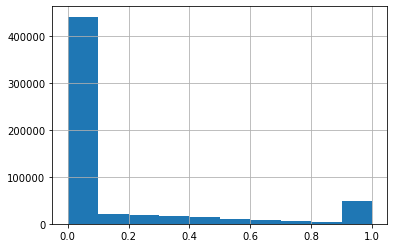

In [ ]:
test["predict"] = preds
test.predict[:5]
if verboseout:
    test.predict.hist()

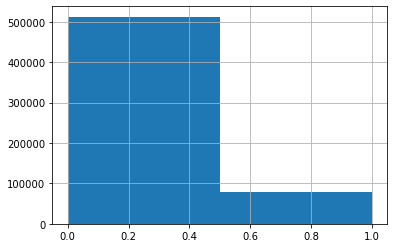

In [ ]:
if verboseout:
    test.predict.hist(bins=2)

In [ ]:
# get rounded predictions
test["predround"] = preds.round().astype(int)
test.predround[:5]

C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


917237    0
346801    0
513886    0
289945    0
358978    1
Name: predround, dtype: int32

In [ ]:
print("test target 0",test[test['target']==0].shape[0])
print("test target 1",test[test['target']==1].shape[0])
print("test predround 0",test[test['predround']==0].shape[0])
print("test predround 1",test[test['predround']==1].shape[0])

test target 0 578427
test target 1 12093
test predround 0 512275
test predround 1 78245


In [ ]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(test.target[:100000] - test.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct test")
print((len(deltatr) - deltatr.sum())/len(deltatr))



12695
percentage correct test
0.87305


In [ ]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=batch_size)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





811053     0.000000
1364770    0.542842
1709203    0.000000
923372     0.000000
1290938    0.000000
Name: predict, dtype: float32

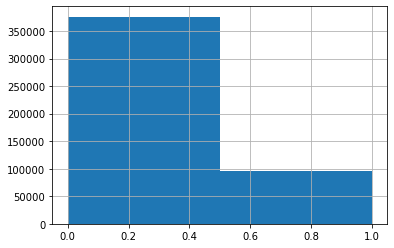

In [ ]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [ ]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


811053     0
1364770    1
1709203    0
923372     0
1290938    0
2138815    0
1896082    0
1883851    0
1217100    0
539580     1
Name: deltaval, dtype: int32
91036


In [ ]:
# hand calculation of proportion correct guesses in validation set

test["deltaval"] = abs(test.target - test.predround)
print(test["deltaval"][:10])
print(test["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))

917237     0
346801     0
513886     0
289945     0
358978     1
2415560    0
643834     0
2263615    1
108015     0
464391     0
Name: deltaval, dtype: int32
75202


C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

Report Date  count  Route  Direction  hour  year  month  daym  day  \
1364770  2016-10-09      0      9          1     4     2      9     8    6   
539580   2015-02-05      0      7          1     9     1      1     4    3   
751605   2015-07-12      0     10          4     9     1      6    11    6   
2107344  2018-04-13      0     10          4     9     4      3    12    4   
2325702  2018-09-22      0      7          4    13     4      8    21    5   
677142   2015-05-18      0      7          1    17     1      4    17    0   
1800223  2017-08-28      0     11          4     6     3      7    27    0   
799820   2015-08-17      0      8          1     2     1      7    16    0   
2030957  2018-02-15      0     13          4    21     4      1    14    3   
2656163  2019-05-25      0      9          1    14     5      4    24    5   
2117895  2018-04-21      0      8          1    15     4      3    20    5   
65855    2014-02-18      0     13          4     6     0      1    17    1   
456734   2014-12-05      0     13          1    10     0     11     4    4   
1638512  2017-04-30      0      9          4    21     3      3    29    6   
1342048  2016-09-22      0     10          4    21     2      8    21    3   
731238   2015-06-27      0      9          1     5     1      5    26    5   
2279955  2018-08-19      0      8          1    12     4      7    18    6   
1772626  2017-08-08      0      4          4     4     3      7     7    1   
94867    2014-03-12      0      8          1    22     0      2    11    2   
2825657  2019-09-28      0      9          1    17     5      8    27    5   

         Min Delay  target  predround   predict  deltaval  
1364770        0.0       0          1  0.542842         1  
539580         0.0       0          1  1.000000         1  
751605         0.0       0          1  0.520703         1  
2107344        0.0       0          1  0.611880         1  
2325702        0.0       0          1  1.000000         1  
677142         0.0       0          1  1.000000         1  
1800223        0.0       0          1  0.539457         1  
799820         0.0       0          1  0.524267         1  
2030957        0.0       0          1  0.702900         1  
2656163        0.0       0          1  0.766252         1  
2117895        0.0       0          1  0.731611         1  
65855          0.0       0          1  0.769492         1  
456734         0.0       0          1  0.677513         1  
1638512        0.0       0          1  0.766853         1  
1342048        0.0       0          1  0.525085         1  
731238         0.0       0          1  0.805126         1  
2279955        0.0       0          1  0.711842         1  
1772626        0.0       0          1  0.609712         1  
94867          0.0       0          1  0.618343         1  
2825657        0.0       0          1  0.743119         1

In [ ]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
testwrong = test.loc[(test.deltaval == 1)]
testright = test.loc[(test.deltaval == 0)]
testwrong.head(20)

Report Date  count  Route  Direction  hour  year  month  daym  day  \
358978   2014-09-24      0      7          1     1     0      8    23    2   
2263615  2018-08-07      0      7          4     8     4      7     6    1   
837958   2015-09-14      0     11          2    12     1      8    13    0   
346903   2014-09-15      0      7          3    13     0      8    14    0   
1835869  2017-09-24      0      4          4    19     3      8    23    6   
2803178  2019-09-11      0     12          4    13     5      8    10    2   
2493120  2019-01-24      0      9          4     7     5      0    23    3   
281971   2014-07-29      0      4          4    19     0      6    28    1   
1259635  2016-07-23      0      8          1    12     2      6    22    5   
1423874  2016-11-22      0      7          1     0     2     10    21    1   
506147   2015-01-11      0      9          4    15     1      0    10    6   
976357   2015-12-26      0      9          1     1     1     11    25    5   
2050223  2018-03-02      0      4          4     4     4      2     1    4   
915623   2015-11-11      0      7          3     7     1     10    10    2   
2409895  2018-11-23      0     12          1    20     4     10    22    4   
2646307  2019-05-18      0      4          4    15     5      4    17    5   
2135384  2018-05-04      0      7          3    14     4      4     3    4   
226268   2014-06-17      0     13          1    19     0      5    16    1   
2655705  2019-05-25      0      4          1    13     5      4    24    5   
2495355  2019-01-26      0      4          4     0     5      0    25    5   

         Min Delay  target   predict  predround  deltaval  
358978         0.0       0  1.000000          1         1  
2263615        0.0       0  1.000000          1         1  
837958         3.0       1  0.000000          0         1  
346903         0.0       0  0.574514          1         1  
1835869        0.0       0  1.000000          1         1  
2803178        6.0       1  0.000000          0         1  
2493120        0.0       0  0.557305          1         1  
281971         0.0       0  1.000000          1         1  
1259635       12.0       1  0.176757          0         1  
1423874        0.0       0  1.000000          1         1  
506147         0.0       0  0.927466          1         1  
976357         0.0       0  0.752488          1         1  
2050223        0.0       0  0.731574          1         1  
915623         0.0       0  1.000000          1         1  
2409895        0.0       0  0.575972          1         1  
2646307        0.0       0  1.000000          1         1  
2135384        0.0       0  0.745008          1         1  
226268         0.0       0  0.566198          1         1  
2655705        0.0       0  1.000000          1         1  
2495355        0.0       0  0.975624          1         1

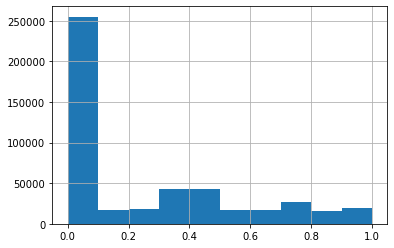

In [ ]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

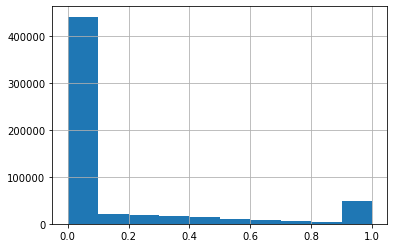

In [ ]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
test.predict.hist()

In [ ]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


19370
percentage correct validate
0.8063


dict_keys(['loss', 'accuracy', 'accuracy_1', 'val_loss', 'val_accuracy', 'val_accuracy_1'])


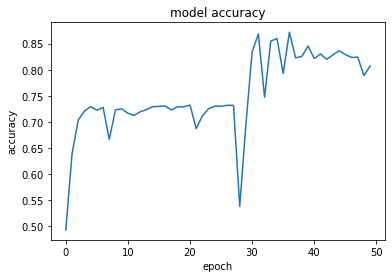

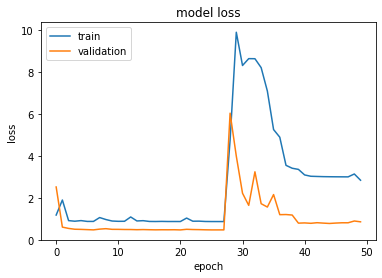

In [ ]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
#plt.plot(modelfit.history['accuracy'])
plt.plot(modelfit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
#plt.legend(['validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

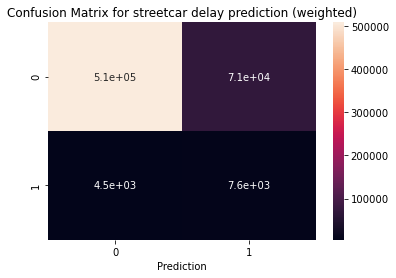

In [ ]:


cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()

In [ ]:
model.metrics_names

['loss', 'accuracy', 'accuracy_1']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at Intact Insurance.